In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [6]:
# reflect the tables
station = Base.classes.station
measurement = Base.classes.measurement

In [7]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns_st = inspector.get_columns('station')
for c in columns_st:
    print(c['name'], c["type"])
engine.execute(text('SELECT * FROM station LIMIT 10')).fetchall()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [9]:
columns_msr = inspector.get_columns('measurement')
for c in columns_msr:
    print(c['name'], c["type"])
engine.execute(text('SELECT * FROM measurement WHERE date="2016-08-24"')).fetchall()

# Save references to each table
#station = Base.classes.station
#measurement = Base.classes.measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(2365, 'USC00519397', '2016-08-24', 0.08, 79.0),
 (5092, 'USC00513117', '2016-08-24', 2.15, 76.0),
 (7332, 'USC00514830', '2016-08-24', 2.28, 80.0),
 (8826, 'USC00517948', '2016-08-24', None, 78.0),
 (11852, 'USC00519523', '2016-08-24', 1.22, 79.0),
 (14609, 'USC00519281', '2016-08-24', 2.15, 77.0),
 (19203, 'USC00516128', '2016-08-24', 1.45, 74.0)]

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(measurement.date).\
    order_by((measurement.date).desc()).first()

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
end_date = dt.datetime(2017, 8, 23)
start_date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
#msr_lastyear = session.query(measurement).\
#    filter(and_(measurement.date >= start_date, measurement.date <= end_date))
msr_lastyear = session.query(measurement).\
    filter((measurement.date >= start_date) & (measurement.date <= end_date))

#for row in msr_lastyear:
#    print(row.id, row.station, row.date, row.prcp, row.tobs)
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ["id", "station", "date", "prcp", "tobs"]
msr_lastyear_df = pd.DataFrame([(row.id, row.station, row.date, row.prcp, row.tobs) for row in msr_lastyear],
                               columns=column_names)

#fill all nan with zero
msr_lastyear_df_noNull = msr_lastyear_df.fillna(0)

# Sort the dataframe by date
msr_lastyear_df.sort_values('date')

# Print df
print(msr_lastyear_df_noNull)

         id      station        date  prcp  tobs
0      2365  USC00519397  2016-08-24  0.08  79.0
1      2366  USC00519397  2016-08-25  0.08  80.0
2      2367  USC00519397  2016-08-26  0.00  79.0
3      2368  USC00519397  2016-08-27  0.00  77.0
4      2369  USC00519397  2016-08-28  0.01  78.0
...     ...          ...         ...   ...   ...
2218  19546  USC00516128  2017-08-19  0.09  71.0
2219  19547  USC00516128  2017-08-20  0.00  78.0
2220  19548  USC00516128  2017-08-21  0.56  76.0
2221  19549  USC00516128  2017-08-22  0.50  76.0
2222  19550  USC00516128  2017-08-23  0.45  76.0

[2223 rows x 5 columns]


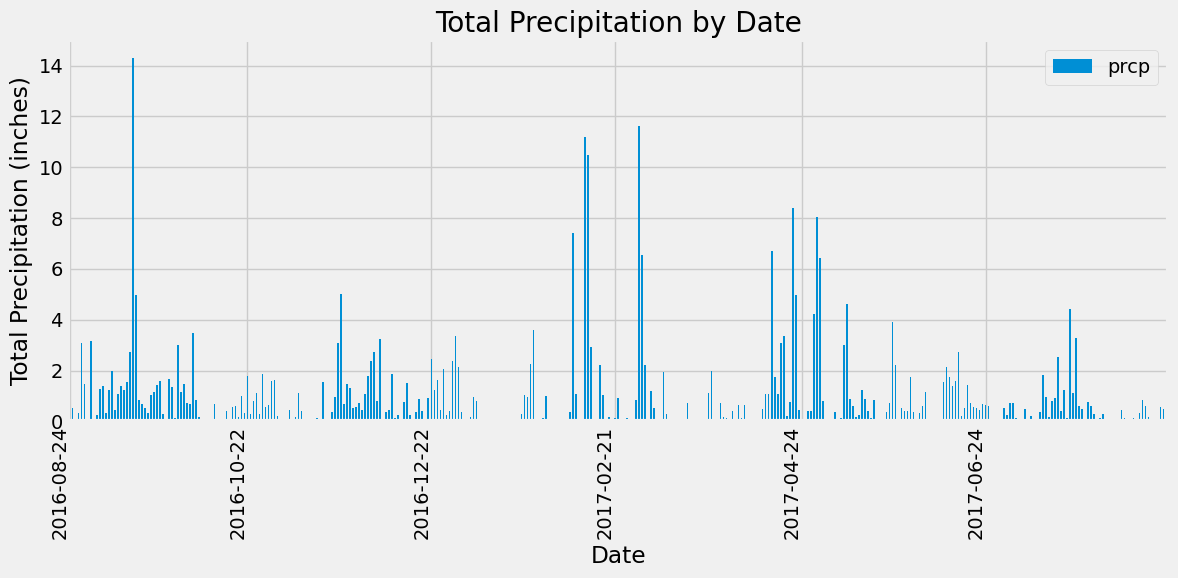

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
# Group date and sum the precipitation per day
plot_prcp_date = msr_lastyear_df_noNull.groupby('date')['prcp'].sum()
plot_prcp_date = plot_prcp_date.reset_index()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12, 6))
plot_prcp_date.plot(kind='bar', x='date', y='prcp', ax=ax)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Total Precipitation (inches)')
ax.set_title('Total Precipitation by Date')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [14]:
plot_prcp_date

,date,prcp
0,2016-08-24,9.33
1,2016-08-25,0.54
2,2016-08-26,0.10
3,2016-08-27,0.32
4,2016-08-28,3.10
...,...,...
360,2017-08-19,0.09
361,2017-08-20,0.01
362,2017-08-21,0.58
363,2017-08-22,0.50


In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Get summary statistics for the 'prcp' column
summary_statistics = plot_prcp_date['prcp'].describe()
print(summary_statistics)


count    365.000000
mean       0.974164
std        1.776466
min        0.000000
25%        0.050000
50%        0.400000
75%        1.080000
max       14.280000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total_stations=session.query(station).\
    order_by(station.station).desc().all()
  #order_by(func.sum(Items.UnitPrice * Items.Quantity).desc()).all()
#engine.execute(text('SELECT * FROM station LIMIT 10')).fetchall()

AttributeError: 'Query' object has no attribute 'desc'

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [ ]:
# Close Session
session.close()